# package

In [5]:
using Distributions
using Random
using LinearAlgebra
using Plots
using StatsBase
using LaTeXStrings
#using ProgressBars
#using ProgressMeter
using DataFrames
using CSV
using Base.Threads
#using StatsPlots
#using Latexify
gr()

Plots.GRBackend()

In [6]:
Threads.nthreads()

36

In [94]:
path = "/Users/nishimurarei/home/lab/data/cubic_data/int/1_001/"

"/Users/nishimurarei/home/lab/data/cubic_data/int/1_001/"

# フォワードモデル

In [7]:
function ini()
    # Hund's Rule Ground J-Multiplet Ce3+ n4f=1
    n4f = 1
    L = 3
    S = 1 / 2
    J = L - S
    g = 1 + (J * (J + 1) + S * (S + 1) - L * (L + 1)) / (2 * J * (J + 1))
    Jz = [5 / 2, 3 / 2, 1 / 2, -1 / 2, -3 / 2, -5 / 2]
    return J, g, Jz
end
J, g, Jz = ini()

(2.5, 0.8571428571428572, [2.5, 1.5, 0.5, -0.5, -1.5, -2.5])

In [8]:
#B20_true = 4
B40_true = 0.1167
#B44_true = 3

0.1167

In [9]:
function Onn_make(B40)
    # O20は不要
    #=
    # O20
    O20_vec = (3 * Jz.^2 .- J*(J+1)) * B20
    O20 = diagm(0 => O20_vec)
    =#
    
    B44 = 5 * B40
    
    # O40
    O40_vec = (35 * Jz.^4 - 30 * J * (J + 1) * Jz.^2 + 25 * Jz.^2 .- 6 * J * (J + 1) .+ 3 * J^2 * (J + 1)^2) * B40
    O40 = diagm(0 => O40_vec)
    
    # O44
    O44 = zeros(6, 6)

    Jz_vec_1 = Jz[1] .- collect(0:3)
    O44[5,1] = sqrt(prod(J .+ Jz_vec_1) * prod((J + 1) .- Jz_vec_1)) * B44 / 2

    Jz_vec_2 = Jz[2] .- collect(0:3)
    O44[6,2] = sqrt(prod(J .+ Jz_vec_2) * prod((J + 1) .- Jz_vec_2)) * B44 / 2

    Jz_vec_5 = Jz[5] .+ collect(0:3)
    O44[1,5] = sqrt(prod(J .- Jz_vec_5) * prod((J + 1) .+ Jz_vec_5)) * B44 / 2

    Jz_vec_6 = Jz[6] .+ collect(0:3)
    O44[2,6] = sqrt(prod(J .- Jz_vec_6) * prod((J + 1) .+ Jz_vec_6)) * B44 / 2

    Onn = O40 + O44

    return Onn
end

Onn_make (generic function with 1 method)

In [10]:
function para()
    Temp_table_chi= collect(0.2:0.2:70) # length 350
    n_chi = length(Temp_table_chi)
    
    #Temp_table_spc = collect(0.5:0.1:50) # length 496
    Temp_table_spc = collect(0.2:0.2:70) # length 350
    n_spc = length(Temp_table_spc)
    
    return Temp_table_chi, Temp_table_spc, n_chi, n_spc
end

Temp_table_chi, Temp_table_spc, n_chi, n_spc = para()

([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0  …  68.2, 68.4, 68.6, 68.8, 69.0, 69.2, 69.4, 69.6, 69.8, 70.0], [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0  …  68.2, 68.4, 68.6, 68.8, 69.0, 69.2, 69.4, 69.6, 69.8, 70.0], 350, 350)

In [11]:
# 磁化率
function chi(Onn)
    magfield = 0.01
    magdir = [0,0,1]
    nor_magdir = magdir / sqrt(sum(magdir.^2))
    
    # 対角要素
    Hmag_vec_0 = Jz * nor_magdir[3] * magfield * g * 0.67171
    Hmag = diagm(0 => Hmag_vec_0)
    
    # 非対角要素はmagdir[x,y]が0なので0
    
    # 結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag

    eigval, eigvec = eigen(H)

    chi_inv_Temp = zeros(n_chi)
    for (i, Temp) in enumerate(Temp_table_chi)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)
        sumexp = sum(exp_eigval)

        mag_z = zeros(6)
        for i in 1:6
            eigvec_check = eigvec[:,i]
            mag_z[i] = eigvec_check' * (eigvec_check .* Jz) * exp_eigval[i] / sumexp
        end

        Jmag_z = sum(mag_z) * g * (-1)
        Jmag = Jmag_z

        chi = Jmag / magfield * 0.5585
        chi_inv = 1 / chi
        chi_inv_Temp[i] = chi_inv
    end
    return chi_inv_Temp
end

chi (generic function with 1 method)

In [12]:
# 比熱
function spc(Onn)
    magfield = 5
    magdir = [1,1,0]
    nor_magdir = magdir / sqrt(sum(magdir.^2))
    # 対角要素 0

    # 非対角要素
    Hmag_vec_1 = sqrt.((J .+ Jz) .* (J .- Jz .+ 1)) * (nor_magdir[1]+nor_magdir[2]*im)*magfield*g*0.67171/2
    Hmag_vec_1 = Hmag_vec_1[1:5]
    Hmag_1 = diagm(1 => Hmag_vec_1)
    
    Hmag_vec_2 = conj.(Hmag_vec_1)
    Hmag_2 = diagm(-1 => Hmag_vec_2)
    
    Hmag = Hmag_1 + Hmag_2

    #結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag

    eigval, eigvec = eigen(H)

    SpcHeat_Temp = zeros(n_spc)
    for (i, Temp) in enumerate(Temp_table_spc)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)

        Z0 = sum(exp_eigval)
        Z1 = sum(eigval_2 .* exp_eigval)
        Z2 = sum(eigval_2.^2 .* exp_eigval)
        
        SpcHeat=(- (Z1/Z0)^2 + (Z2/Z0) )*8.31441
        SpcHeat_Temp[i] = SpcHeat
    end
    return SpcHeat_Temp
end

spc (generic function with 1 method)

# データ作成

In [13]:
#gaussian noise std
noise_chi = 10^1
noise_spc = 10^0

1

In [14]:
b_chi = (1 / noise_chi)^2
b_spc = (1 / noise_spc)^2

1.0

In [15]:
function making_data()
    
    d_chi = Normal(0,noise_chi)
    chi_inv_Temp = chi(Onn_make(B40_true))
    chi_inv_Temp_noise = chi_inv_Temp + rand(d_chi,n_chi)
    
    d_spc = Normal(0,noise_spc)
    SpcHeat_Temp = spc(Onn_make(B40_true))
    SpcHeat_Temp_noise = SpcHeat_Temp + rand(d_spc,n_spc)
    
    return chi_inv_Temp, chi_inv_Temp_noise, SpcHeat_Temp, SpcHeat_Temp_noise
end

making_data (generic function with 1 method)

In [16]:
chi_inv_Temp, chi_inv_Temp_noise, SpcHeat_Temp, SpcHeat_Temp_noise = making_data()

([1.0142098958967294, 1.9698907987548453, 2.8722754814654956, 3.7256615033986065, 4.533926703861032, 5.300555018574956, 6.028682004468414, 6.721136550981254, 7.380477230718577, 8.009023734337188  …  86.32067293585246, 86.56483755431333, 86.80903037778333, 87.05325115358977, 87.29749963202654, 87.54177556640121, 87.78607871277933, 88.03040883012414, 88.274765680143, 88.5191490273593], [10.569998688304263, -3.9225959128647916, -3.6331673445945802, 9.205255606831129, -3.7795817027532843, 0.012481216853323929, 16.05578228712641, 5.040582669241241, 18.835909513093014, 10.41804066865907  …  77.56341564137875, 82.15135113244264, 87.43853012957271, 84.18178703835301, 87.06983666551211, 91.66141368462948, 79.78147336704188, 81.222228563321, 81.349444349571, 94.02438737470098], [2.0459508683416062e-7, 0.007781692852308807, 0.18450030396517358, 0.7549227999732644, 1.5747619137726376, 2.3742479457198407, 2.9941230896750977, 3.394038269972245, 3.5980299505842, 3.651784803576995  …  0.82616286863923

# 作成データ可視化

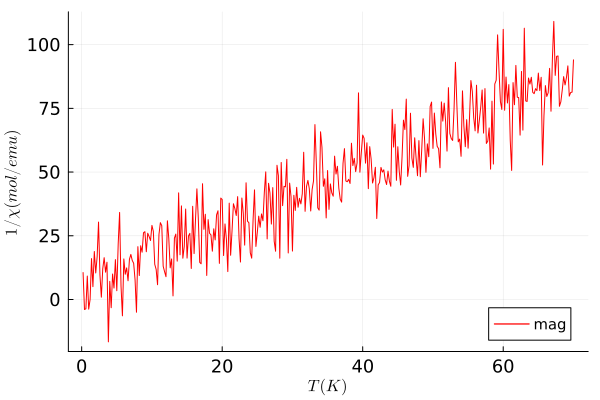

In [17]:
#chi

plot(Temp_table_chi, chi_inv_Temp_noise,label="mag",color="red")
plot!(xlabel=L"T(K)",ylabel=L"1/\chi(mol/emu)")
plot!(legendfontsize=10,xtickfont=font(12), ytickfont=font(12))
plot!(legend=:bottomright)

In [18]:
#save_path_chi = path * "data_chi_1.pdf"
#savefig(save_path_chi)

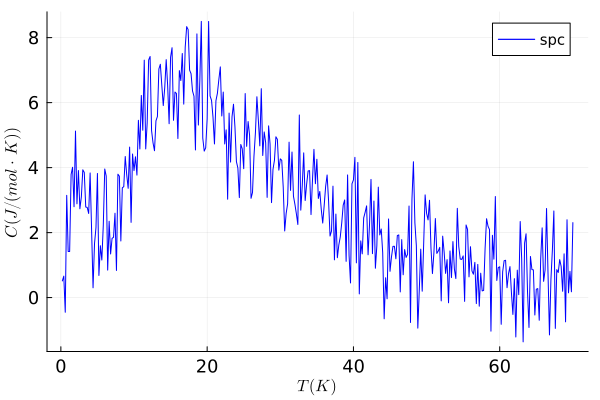

In [19]:
#spc
plot(Temp_table_spc,  SpcHeat_Temp_noise ,label="spc",color="blue")
plot!(xlabel=L"T(K)",ylabel=L"C(J/(mol \cdot K))")
plot!(legendfontsize=10,xtickfont=font(12), ytickfont=font(12))
plot!(legend=:topright)

In [20]:
#save_path_spc = path * "data_spc_001.pdf"
#savefig(save_path_spc)

# データ保存

In [21]:
#=
df_chi = DataFrame(
    true_data = chi_inv_Temp,
    noise_data = chi_inv_Temp_noise
)
=#

In [22]:
#df_chi |> CSV.write(path * "chi_data.csv",delim=",",writeheader=true)

# hyper parameter chi

In [23]:
function para_chi()
    L = 70
    gamma = 1.3
    return L, gamma
end
L_chi, gamma_chi = para_chi()

(70, 1.3)

In [24]:
#chi_parameter_B40
function para_chi_B40()
    C = 0.05 #stepsize
    d = 1.2
    return C, d
end
C_chi_B40, d_chi_B40 = para_chi_B40()

(0.05, 1.2)

In [25]:
#=
df_chi_para = DataFrame(
    name = ["L","gamma","d"],
    B40 = [L_chi, gamma_chi, d_chi_B40],
)
=#

In [26]:
#df_chi_para |> CSV.write(path * "chi_para.csv",delim=",",writeheader=true)

# 逆温度リスト

In [27]:
function beta_list_chi()
    beta_chi = zeros(L_chi)
    
    for i in 2:L_chi
        beta_chi[i] = gamma_chi^(i - L_chi)
    end
    
    return beta_chi
end
beta_chi = beta_list_chi()

70-element Vector{Float64}:
 0.0
 1.7858790520831557e-8
 2.3216427677081022e-8
 3.0181355980205335e-8
 3.923576277426693e-8
 5.100649160654702e-8
 6.630843908851112e-8
 8.620097081506447e-8
 1.120612620595838e-7
 1.4567964067745895e-7
 1.8938353288069665e-7
 2.4619859274490565e-7
 3.200581705683773e-7
 ⋮
 0.05579857714338899
 0.07253815028640569
 0.0942995953723274
 0.12258947398402563
 0.15936631617923333
 0.20717621103300332
 0.2693290743429043
 0.35012779664577565
 0.45516613563950836
 0.5917159763313609
 0.7692307692307692
 1.0

In [28]:
function step_list_chi()
    step_chi_B40 = ones(L_chi) * C_chi_B40
    
    for i in 1:L_chi
        if n_chi * beta_chi[i]  > 1
            step_chi_B40[i] = C_chi_B40 / (n_chi * beta_chi[i])^d_chi_B40
        end
    end
    
    return step_chi_B40
    
end

step_chi_B40 = step_list_chi()

70-element Vector{Float64}:
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 ⋮
 0.0014129949235473155
 0.0010313559509019467
 0.0007527947055821391
 0.0005494706926904399
 0.00040106291912910994
 0.000292738934469401
 0.00021367241813420555
 0.00015596115478821293
 0.00011383725618528509
 8.309069597100485e-5
 6.064854326520916e-5
 4.42678419913043e-5

In [29]:
#=
df_chi_step = DataFrame(
    B40 = step_chi_B40
)
=#

In [30]:
#df_chi_step |> CSV.write(path * "chi_step.csv",delim=",",writeheader=true)

# 誤差関数

In [31]:
function error_chi(B40)
    error_value = sum((chi_inv_Temp_noise - chi(Onn_make(B40))).^2)/(2*n_chi)
    return error_value
end

error_chi (generic function with 1 method)

In [32]:
function error_list_chi(B40_list)
    error_ls = zeros(L_chi)
    @threads for i in 1:L_chi
        error_ls[i] = error_chi(B40_list[i])
    end
    return error_ls
end

error_list_chi (generic function with 1 method)

# 誤差関数最小パラメータ確認

In [33]:
#B40_sample = collect(-100:0.01:100)

In [34]:
#=
error_sample_list = zeros(length(B40_sample))
@threads for i in 1:length(B40_sample)
    error_sample_list[i] = error_chi(B40_sample[i])
end
=#

In [35]:
#plot(B40_sample,error_sample_list,legend=:false)
#plot!(xlabel=L"B40",ylabel="error")

In [36]:
#savefig(path * "chi_error_B40.pdf")

In [37]:
#B40_sample = collect(0:0.0001:1)

In [38]:
#=
error_sample_list = zeros(length(B40_sample))
@threads for i in 1:length(B40_sample)
    error_sample_list[i] = error_chi(B40_sample[i])
end
=#

In [39]:
#plot(B40_sample,error_sample_list,legend=:false)
#plot!(xlabel=L"B40",ylabel="error")

In [40]:
#savefig(path * "chi_error_B40_focus.pdf")

In [41]:
#=
para_min = B40_sample[argmin(error_sample_list)]
para_dif = abs(para_min - B40_true)
println("para_min:",para_min)
println("true_para:",B40_true)
println("dif:", para_dif)
=#

In [42]:
#=
df_chi_para_error = DataFrame(
    true_para = B40_true,
    min_para = para_min
)
=#

In [43]:
#df_chi_para_error |> CSV.write(path * "chi_para_error.csv",delim=",",writeheader=true)

# 事前分布

In [44]:
function cauchy(x,x0,gamma)
    f = (1/pi) * (gamma/((x-x0)^2+gamma^2))
    return f
end

cauchy (generic function with 1 method)

In [45]:
function prior(B40)
    prior_B40 = cauchy(B40,0,5)
    return prior_B40
end

prior (generic function with 1 method)

In [46]:
function prior_list(B40_list)
    prior_list = zeros(L_chi)
    for i in 1:L_chi
        prior_list[i] = prior(B40_list[i])
    end
    return prior_list
end

prior_list (generic function with 1 method)

# EXMC

In [47]:
# metropolis
function metropolis_chi(B40_list, saitaku)
    
    B40_proposed = B40_list + rand(L_chi) .* rand([-1,1],L_chi) .* step_chi_B40
    
    #事前分布
    prior_ratio = prior_list(B40_proposed) ./ prior_list(B40_list)
    
    err_proposed = error_list_chi(B40_proposed)
    err_ini = error_list_chi(B40_list)
    
    error_dif = err_proposed - err_ini
    
    bit_vec = rand(L_chi) .< exp.(- n_chi * b_chi * beta_chi .* error_dif) .* prior_ratio
    
    for i in 1:L_chi
        if bit_vec[i] == 0 # 交換しない
            B40_proposed[i] = B40_list[i]
        else #交換
            saitaku[i] += 1
        end
    end
    
    return B40_proposed, saitaku, err_ini
end

metropolis_chi (generic function with 1 method)

In [48]:
function exchange_chi(B40_list, koukann, koukann_total)

    for l in 1:L_chi-1
        #レプリカからランダムに選択
        #l = rand(collect(1:L_chi-1))
        #ランダムに選ぶことをやめて、順番に行う
        
        beta_dif = beta_chi[l + 1] - beta_chi[l]
        error_dif = error_chi(B40_list[l + 1]) - error_chi(B40_list[l])
        v = exp(n_chi * b_chi * beta_dif * error_dif)
        u = minimum([1,v])
        items = [1,0]
        weights = [u,1 - u]
        item = sample(items, Weights(weights)) # 1で交換
        
        #交換
        if item == 1
            B40_list[l + 1], B40_list[l] = B40_list[l], B40_list[l + 1]
            koukann[l] += 1
        else
            koukann[l] += 0
        end

        #レプリカ選択の記録
        koukann_total[l] += 1
    end

    return B40_list, koukann, koukann_total
end

exchange_chi (generic function with 1 method)

In [51]:
# exmc
function emc_chi(size_simu, frequency_exchange)
    # 初期パラメータ値
    #真値付近からスタート
    B40_list = B40_true .+ rand(L_chi) * 5
    
    #格納用(beta=1の値を保存)
    B40_keep = zeros(size_simu,L_chi)
    
    #採択率,交換率記録
    saitaku = zeros(L_chi)
    koukann = zeros(L_chi)
    koukann_total = zeros(L_chi)
    
    #各温度誤差関数の値記録
    error_func_list = zeros(size_simu,L_chi)
    
    # 更新
    #r = Progress(size_simu; showspeed=true)

    show_iter = Int64(size_simu / 10)
    for iter in 1:size_simu
        B40_list, saitaku, error_ini = metropolis_chi(B40_list, saitaku)
        error_func_list[iter, :] = error_ini
        
        if iter % frequency_exchange == 0
           B40_list, koukann, koukann_total = exchange_chi(B40_list, koukann, koukann_total)
        end
        
        B40_keep[iter,:] = B40_list
        
        #ProgressMeter.next!(r)
        if iter % show_iter == 0
            print_num = iter / show_iter * 10
            print("finish", print_num "percent")
    end
    
    saitaku = saitaku / size_simu
    
    koukann = koukann ./ koukann_total
    
    return B40_keep, saitaku, koukann, error_func_list
end

emc_chi (generic function with 1 method)

In [52]:
mc_step = 100000
exchange_frequency = 3

3

In [53]:
B40_list_chi, saitaku_chi, koukann_chi, error_func_list_chi = emc_chi(mc_step, exchange_frequency)

Progress: 100%|███████████████████████████| Time: 4:01:54 ( 0.15  s/it)


([0.7459891977723145 0.7459891977723145 … 0.6959285492290492 0.6959449299303232; 0.7959891977723146 0.6959891977723145 … 0.695867900685784 0.6959449299303232; … ; -6.732702676969787 1.6791464420817919 … 0.11650537106305092 0.11728605992412994; -6.7827026769697865 1.6291464420817918 … 0.11644472251978571 0.11733032776612125], [0.99651, 0.99663, 0.9965, 0.99604, 0.99622, 0.9961, 0.99646, 0.99654, 0.99615, 0.99593  …  0.89381, 0.91104, 0.92598, 0.93549, 0.94831, 0.95506, 0.9623, 0.96794, 0.97263, 0.97769], [0.9942840041897352, 0.9983583559681223, 0.9979621804669004, 0.9974990960588165, 0.9966679674601507, 0.994981779078798, 0.9933628986031918, 0.9923296143584769, 0.9903803065156992, 0.9885627258339057  …  0.9141964285714286, 0.9159449821701477, 0.9125890878600946, 0.9112363930788376, 0.9107684909686533, 0.9091421954333561, 0.90350405921681, 0.9080359820089955, 0.9023136246786633, NaN], [914.9413566113552 914.9413566113552 … 914.9413566113552 914.9413566113552; 1057.8094733231223 1057.8094

# 温度、採択率、交換率

In [54]:
df_vin_chi = DataFrame(
    beta_temp = beta_chi,
    
    B40 = step_chi_B40,
    採択率_B40 = saitaku_chi,
     
    交換率 = koukann_chi
)

,beta_temp,B40,採択率_B40,交換率
,Float64,Float64,Float64,Float64
1,0.0,0.05,0.99651,0.994284
2,1.78588e-8,0.05,0.99663,0.998358
3,2.32164e-8,0.05,0.9965,0.997962
4,3.01814e-8,0.05,0.99604,0.997499
5,3.92358e-8,0.05,0.99622,0.996668
6,5.10065e-8,0.05,0.9961,0.994982
7,6.63084e-8,0.05,0.99646,0.993363
8,8.6201e-8,0.05,0.99654,0.99233
9,1.12061e-7,0.05,0.99615,0.99038


In [55]:
df_vin_chi |> CSV.write(path * "vin_chi.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/cubic_data/check/chi/vin_chi.csv"

In [56]:
latexify(df_vin_chi; env=:table, latex=false)

L"\begin{tabular}{cccc}
beta_temp & B40 & 採択率_B40 & 交換率\\
0.0 & 0.05 & 0.99651 & 0.9942840041897352\\
1.7858790520831557e-8 & 0.05 & 0.99663 & 0.9983583559681223\\
2.3216427677081025e-8 & 0.05 & 0.9965 & 0.9979621804669004\\
3.0181355980205335e-8 & 0.05 & 0.99604 & 0.9974990960588165\\
3.923576277426693e-8 & 0.05 & 0.99622 & 0.9966679674601507\\
5.100649160654702e-8 & 0.05 & 0.9961 & 0.994981779078798\\
6.630843908851112e-8 & 0.05 & 0.99646 & 0.9933628986031918\\
8.620097081506447e-8 & 0.05 & 0.99654 & 0.9923296143584769\\
1.120612620595838e-7 & 0.05 & 0.99615 & 0.9903803065156992\\
1.4567964067745895e-7 & 0.05 & 0.99593 & 0.9885627258339057\\
1.8938353288069665e-7 & 0.05 & 0.99583 & 0.9846784570727474\\
2.4619859274490565e-7 & 0.05 & 0.99559 & 0.9804939155332856\\
3.2005817056837737e-7 & 0.05 & 0.99517 & 0.9776178328474247\\
4.1607562173889056e-7 & 0.05 & 0.99504 & 0.9745670995670995\\
5.408983082605578e-7 & 0.05 & 0.99444 & 0.9716792503506521\\
7.031678007387251e-7 & 0.05 & 0.99384 &

# 保存

In [57]:
df_B40_chi = DataFrame(
    B40_list_chi, :auto
)

,x1,x2,x3,x4,x5,x6,x7,x8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.745989,0.745989,0.645989,0.645989,0.645989,0.745989,0.645989,0.745989
2,0.795989,0.695989,0.595989,0.595989,0.695989,0.695989,0.595989,0.695989
3,0.545989,0.745989,0.745989,0.545989,0.745989,0.545989,0.745989,0.645989
4,0.495989,0.695989,0.695989,0.595989,0.695989,0.595989,0.695989,0.695989
5,0.545989,0.745989,0.745989,0.645989,0.745989,0.545989,0.745989,0.645989
6,0.795989,0.795989,0.495989,0.695989,0.695989,0.495989,0.695989,0.695989
7,0.845989,0.845989,0.545989,0.745989,0.645989,0.545989,0.745989,0.745989
8,0.895989,0.895989,0.595989,0.695989,0.595989,0.595989,0.795989,0.795989
9,0.945989,0.645989,0.845989,0.545989,0.845989,0.645989,0.845989,0.645989


In [59]:
df_B40_chi |> CSV.write(path * "para_B40_chi.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/cubic_data/check/chi/para_B40_chi.csv"

In [60]:
df_error_chi = DataFrame(
    error_func_list_chi, :auto
)
df_error_chi |> CSV.write(path * "error_chi.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/cubic_data/check/chi/error_chi.csv"

# 自由エネルギー

In [61]:
#check_free_energy
function find_free_energy_chi(error_func_list,burn_in)
    #バーンイン後のエネルギー関数抽出
    error_func_check = error_func_list[burn_in+1:end,1:end-1]
    
    #温度差
    beta_dif = beta_chi[2:end] - beta_chi[1:end-1]
    
    #温度差をかける
    for replica in 1:L_chi-1
        error_func_check[:,replica] *= beta_dif[replica]
    end
    
    #n,noiseをかける
    error_func_check *= - n_chi* b_chi
    
    #最大値取得
    error_func_check_max = zeros(L_chi-1)
    for replica in 1:L_chi-1
        error_func_check_max[replica] = maximum(error_func_check[:,replica])
    end
    
    #最大値で引いたエネルギー関数
    error_func_check_dif = copy(error_func_check)
    for replica in 1:L_chi-1
        error_func_check_dif[:,replica] = error_func_check[:,replica] .- error_func_check_max[replica]
    end
    
    #expの肩にのせる
    error_func_check_dif = exp.(error_func_check_dif)
    
    #各レプリカごとで先程の最大値を引いた差の和をとる
    sum_for_replica = zeros(L_chi-1)
    for replica in 1:L_chi-1
        sum_for_replica[replica] = sum(error_func_check_dif[:,replica])
    end
    
    #各レプリカごとで計算
    for_replica = zeros(L_chi-1)
    for replica in 1:L_chi-1
        for_replica[replica] = error_func_check_max[replica] + log(sum_for_replica[replica]) - log(size(error_func_list)[1] - burn_in)
    end
    
    #自由エネルギー
    free_energy = - n_chi/2*(log(b_chi)-log(2*pi)) - sum(for_replica)
    
    return free_energy
end

find_free_energy_chi (generic function with 1 method)

In [62]:
free_energy_chi = find_free_energy_chi(error_func_list_chi, Int(mc_step/2))
free_energy_chi

510.0813112481385

In [63]:
df_free_energy = DataFrame(自由エネルギー = free_energy_chi)
df_free_energy |> CSV.write(path * "free_energy.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/cubic_data/check/chi/free_energy.csv"

# 自由エネルギー変化

In [76]:
list_end = Vector(10000:10000:mc_step)

10-element Vector{Int64}:
  10000
  20000
  30000
  40000
  50000
  60000
  70000
  80000
  90000
 100000

In [77]:
list_start = Vector(1:10000:mc_step)
list_start = list_start[1:length(list_end)]

10-element Vector{Int64}:
     1
 10001
 20001
 30001
 40001
 50001
 60001
 70001
 80001
 90001

In [78]:
free_energy_list = zeros(length(list_start))
for i in 1:length(list_start)
    free_energy_list[i] = find_free_energy_chi(error_func_list_chi[list_start[i]:list_end[i],:],0)
end

In [79]:
free_energy_list

10-element Vector{Float64}:
 509.64453954333
 510.0622165880547
 509.91197535333043
 510.8417960326417
 511.8576076068447
 511.2001082927348
 509.8703193205462
 509.7378188815461
 509.78540415353694
 509.9237719862012

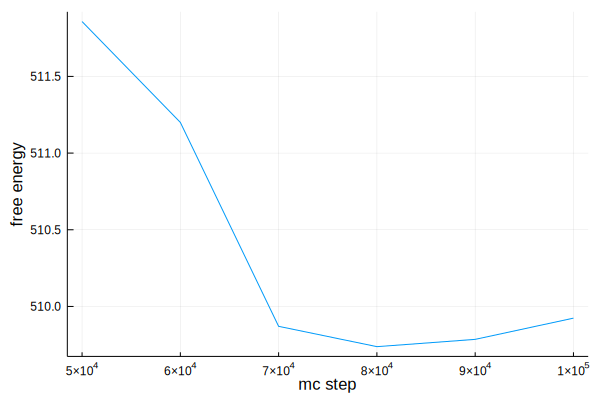

In [84]:
start_num = 5
plot(list_end[start_num:end],free_energy_list[start_num:end])
plot!(xlabel="mc step",ylabel="free energy")
plot!(legend=false)

In [85]:
savefig(path * "free_energy_change.pdf")

# 事後分布

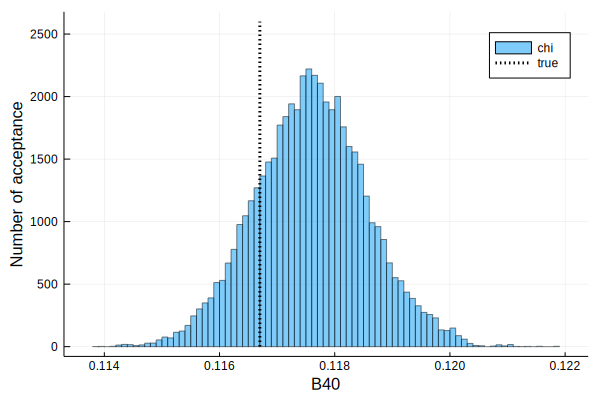

In [87]:
burn_in = Int(mc_step/2)
true_height = 2600

p1 = plot(B40_list_chi[burn_in:end,end],st=:histogram,label="chi",alpha=0.5,color=palette(:default)[1]) #yaxis=:logでlog
p1 = plot!(xlabel="B40",ylabel="Number of acceptance")
p1 = plot!(B40_true*ones(true_height),collect(1:true_height), linestyle=:dot,linewidth = 3,label="true",color=:black)

In [89]:
savefig(path * "chi_hist.pdf")

# 平均、分散

In [90]:
chi_mean = mean(B40_list_chi[burn_in:end,end])
chi_mean

0.11759090382822131

In [91]:
chi_std = std(B40_list_chi[burn_in:end,end])
chi_std

0.0009698521108858111

In [92]:
df_mean_std = DataFrame(
    mean = chi_mean,
    std = chi_std
)

,mean,std
,Float64,Float64
1,0.117591,0.000969852


In [93]:
df_mean_std |> CSV.write(path * "mean_std_chi.csv",delim=",",writeheader=true)

"/Users/nishimurarei/home/lab/data/cubic_data/check/chi/mean_std_chi.csv"